##### Master Degree in Computer Science and Data Science for Economics

# Word2Vec
## A toy example and from scratch implementation

### Alfio Ferrara

For the details about the model, see [wordvec.py](./nlp/wordvec.py)

## A simple toy dataset
Let's take a simple example with pseudo docs representing different weather conditions

In [1]:
import json

In [2]:
with open('../data/weather.json', 'r') as file_in:
    data = json.load(file_in)
weather = data['weather']
for doc in weather:
    print(" | ".join(doc))

mountains | snow | ice | peak | woods | cold
beach | sand | sea | wave | sun | hot
desert | dune | cactus | sand | sun | arid
forest | tree | leaf | animal | rain | humidity
river | water | fish | spring | current | bank
sky | cloud | wind | rain | thunder | rainbow


## Create SkipGram dataloader

In [4]:
import nlp.wordbags as wb
import pandas as pd
import torch 

In [5]:
bow = wb.Bow(corpus=weather)
data_loader, inputs, outputs = bow.one_hot_skip_gram_dataloader(window=2, batch=2)

In [10]:
readable_input = pd.DataFrame(inputs, columns=bow.vocabulary)
readable_input.iloc[2].head()

mountains    0.0
snow         0.0
ice          1.0
peak         0.0
woods        0.0
Name: 2, dtype: float32

In [11]:
readable_target = pd.DataFrame(outputs, columns=bow.vocabulary)
readable_target.iloc[2].head()

mountains    1.0
snow         1.0
ice          0.0
peak         1.0
woods        1.0
Name: 2, dtype: float32

In [12]:
for x, y in data_loader:
    print(f"Input: {x}")
    print(f"Target: {y}")
    break 

Input: tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
Target: tensor([[0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [13]:
for i, (x, y) in enumerate(data_loader):
    for batch_i in range(x.shape[0]):
        x_indices = torch.where(x[batch_i] == 1)[0].numpy()
        y_indices = torch.where(y[batch_i] == 1)[0].numpy()
        input_word = f"{[bow.idx2word[w_x] for w_x in x_indices]}"
        target_word = f"{[bow.idx2word[w_y] for w_y in y_indices]}"
        print(f"{input_word} ==> {target_word}")
    if i > 5:
        break 

['mountains'] ==> ['snow', 'ice']
['snow'] ==> ['mountains', 'ice', 'peak']
['ice'] ==> ['mountains', 'snow', 'peak', 'woods']
['peak'] ==> ['snow', 'ice', 'woods', 'cold']
['woods'] ==> ['ice', 'peak', 'cold']
['cold'] ==> ['peak', 'woods']
['beach'] ==> ['sand', 'sea']
['sand'] ==> ['beach', 'sea', 'wave']
['sea'] ==> ['beach', 'sand', 'wave', 'sun']
['wave'] ==> ['sand', 'sea', 'sun', 'hot']
['sun'] ==> ['sea', 'wave', 'hot']
['hot'] ==> ['wave', 'sun']
['desert'] ==> ['dune', 'cactus']
['dune'] ==> ['sand', 'desert', 'cactus']


## Build and train a predictor

In [14]:
from nlp.wordvec import Word2WordPrediction, Word2VecModel
from nlp.w2w_readers import WordEmbeddings

In [15]:
w2w = Word2WordPrediction(input_dim=bow.size, hidden_dim=4)
epochs = 150
learning_rate = 0.01
history = w2w.train(data_loader=data_loader, epochs=epochs, 
                    learning_rate=learning_rate)
print(history[0], history[-1])

100%|██████████| 150/150 [00:00<00:00, 378.61it/s]

10.489610566033257 9.70918639500936


### Predict next word

In [16]:
model = WordEmbeddings(words=bow, model=w2w)

In [17]:
model['desert']

array([ 1.4952008,  1.8044807, -2.0057607,  1.8080912], dtype=float32)

In [19]:
query = 'desert'
next_word = model.predict(query, topk=10)
next_word

cactus     0.999547
sun        0.000129
wave       0.000090
sand       0.000084
snow       0.000048
ice        0.000037
thunder    0.000031
arid       0.000011
fish       0.000007
dune       0.000004
dtype: float32

### Generate text

In [20]:
import numpy as np 

In [21]:
start = "desert"
text = [start]
for i in range(6):
    p = model.predict(start)
    next_word = np.random.choice(p.index.values, p=p.values / p.values.sum())
    text.append(next_word)
    start = next_word

print(" ".join(text))

desert cactus sand sun cactus sun cactus


## Word Embeddings

In [25]:
search = 'desert'

In [26]:
model[search]

array([ 1.4952008,  1.8044807, -2.0057607,  1.8080912], dtype=float32)

### Most similar

In [27]:
model.most_similar(search, topk=10)

desert       1.000000
sun          0.998976
sand         0.845867
hot          0.394564
peak         0.375409
mountains    0.350478
rainbow      0.315851
wind         0.300190
cactus       0.285786
sea          0.281450
Name: desert, dtype: float32

### Visual map

In [28]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-dark-palette')

In [29]:
tsne = TSNE(n_components=2)
vectors = model.vectors(bow.vocabulary)
v2d = tsne.fit_transform(vectors)

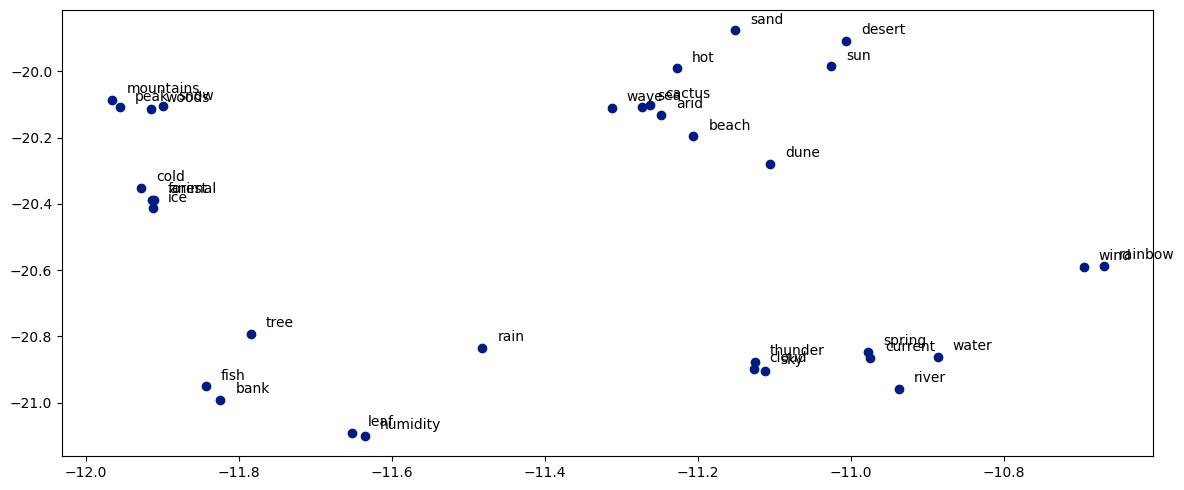

In [30]:
selected_words = bow.vocabulary
indexes = [bow.word2idx[w] for w in selected_words]
selected2d = v2d[indexes]

fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(selected2d[:,0], selected2d[:, 1])
for i, w in enumerate(selected_words):
    ax.text(selected2d[i][0] + .02, selected2d[i][1] + .02, w)
plt.tight_layout()
plt.show()

### Clustering

In [31]:
from sklearn.cluster import AffinityPropagation
from collections import defaultdict
import seaborn as sns

In [32]:
ap = AffinityPropagation()
assignments = ap.fit_predict(selected2d)
clusters = defaultdict(list)
for i, cluster in enumerate(assignments):
    clusters[cluster].append(selected_words[i])

/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/Flint/.pyenv/versions/nlp/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [33]:
for cluster, words in clusters.items():
    print(f"Cluster {cluster}: {', '.join(words)}")

Cluster 0: mountains, snow, ice, peak, woods, cold, forest, animal
Cluster 1: beach, sand, sea, wave, sun, hot, desert, dune, cactus, arid
Cluster 3: tree, leaf, rain, humidity, fish, bank
Cluster 2: river, water, spring, current, sky, cloud, wind, thunder, rainbow


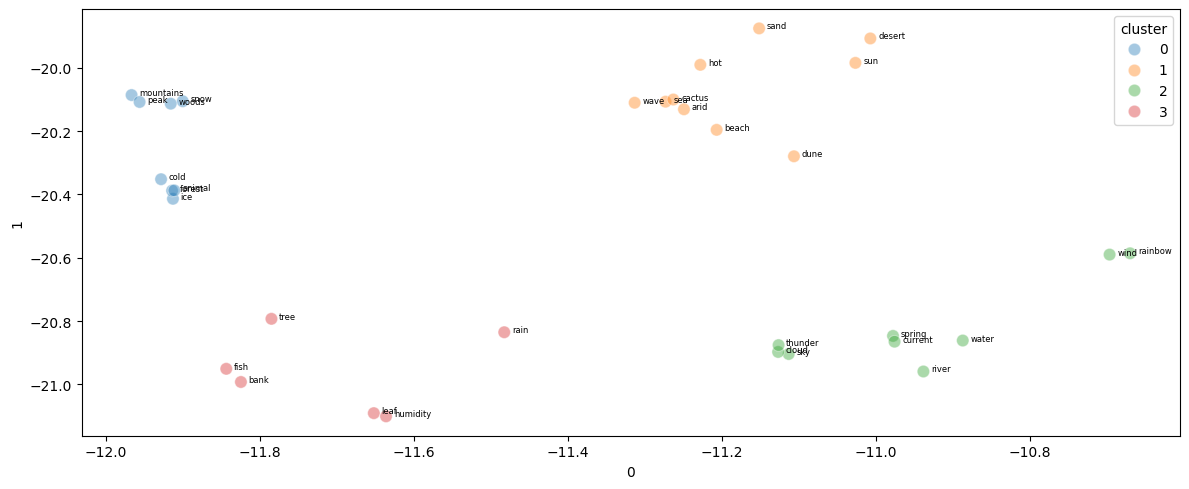

In [34]:
dfsample = pd.DataFrame(selected2d)
dfsample['word'] = selected_words
dfsample['cluster'] = assignments


fig, ax = plt.subplots(figsize=(12, 5))
scatter = sns.scatterplot(
    data=dfsample,
    x=0,
    y=1,
    hue="cluster",
    s=80,
    palette="tab10",
    legend="full",
    ax=ax,
    alpha=0.4
)
for i in range(len(dfsample)):
    plt.text(dfsample[0][i] + 0.01, dfsample[1][i], dfsample.word[i], fontsize=6)
plt.tight_layout()
plt.show()

### Directions

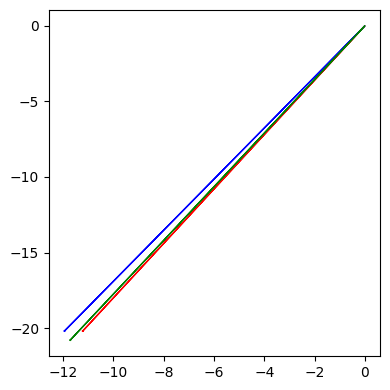

In [35]:
def pointer(group, vectors):
    g = vectors[[bow.word2idx[w] for w in group]]
    return g.mean(axis=0)

group1 = ['dune', 'beach', 'cactus', 'arid']
group2 = ['snow', 'peak', 'mountains', 'ice']
group3 = ['forest', 'tree', 'rain', 'humidity']
g1 = pointer(group1, v2d)
g2 = pointer(group2, v2d)
g3 = pointer(group3, v2d)

fig, ax = plt.subplots(figsize=(4, 4))
ax.arrow(0, 0, g1[0], g1[1], head_width=0.05, head_length=0.05, fc='red', ec='red')
ax.arrow(0, 0, g2[0], g2[1], head_width=0.05, head_length=0.05, fc='blue', ec='blue')
ax.arrow(0, 0, g3[0], g3[1], head_width=0.05, head_length=0.05, fc='green', ec='green')
plt.tight_layout()
plt.show()

## Compositionality

In [36]:
model.search(positive=['desert'], negative=['dune'])

desert     0.691423
sun        0.662972
sand       0.645870
fish       0.578497
bank       0.568419
rainbow    0.546341
wind       0.537156
peak       0.379161
woods      0.366860
snow       0.360757
dtype: float32

In [37]:
answer, a_vector = model.analogy('sea', 'wave', 'desert')
print(answer)

desert


In [39]:
model.common_meanings(['sea', 'wave', 'desert', 'sand'])

sand      0.903388
cactus    0.817192
sea       0.814555
hot       0.802935
arid      0.792848
sun       0.780531
wave      0.767357
desert    0.766879
beach     0.536476
dune      0.509255
dtype: float32

In [40]:
model.spot_odd_one(words=['mountains', 'peak', 'snow', 'sand'])

sand         0.527771
snow         0.845736
mountains    0.876254
peak         0.880175
dtype: float32

In [41]:
model.search(positive=['sea'], negative=['wave'])

sun        0.817765
desert     0.812993
water      0.670348
rainbow    0.656974
wind       0.645852
spring     0.579713
current    0.567438
sand       0.550569
river      0.510515
bank       0.128851
dtype: float32

In [42]:
model.search(positive=['dune', 'sea'], negative=['wave'])

dune       0.996616
beach      0.976459
arid       0.725235
cactus     0.723268
sea        0.723005
wave       0.700903
spring     0.389049
current    0.371997
river      0.348420
sun        0.328809
dtype: float32